In [1]:
from __future__ import division
import numpy as np
import sys
from scipy import special as sp

In [2]:
#Universal Constants
c = 3e8
G = 6.67e-11
Msolar = 2e30
AU = 1.49e11 #meters

In [3]:
def NicePlot(zoom):
    

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    ax1.tick_params(axis='both', which='major', labelsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=25)
    ax3.tick_params(axis='both', which='major', labelsize=25)
    ax4.tick_params(axis='both', which='major', labelsize=25)
    ax5.tick_params(axis='both', which='major', labelsize=25)




    ax1.set_ylabel('$e$', fontsize = 25)
    ax2.set_ylabel(r'$\sin(\gamma)$', fontsize = 25)
    ax4.set_ylabel(r'$h_{+}$', fontsize = 25)
    ax5.set_ylabel(r'$h_{\times}$', fontsize = 25)
    
    
    ax5.set_xlabel('t [yr]', fontsize = 25)
    
    

    if zoom == 1:
        lim = 0.1
        
        ax1.set_xlim(0,lim)
        ax2.set_xlim(0,lim)
        ax3.set_xlim(0,lim)  
        ax4.set_xlim(0,lim)  
        ax5.set_xlim(0,lim)

    

def sma(M,f):
    #Total mass, orbital frequency
    return (G*M/(2*np.pi*f)**2)**(1/3)

def ang_mom(m1,m2,a):
    M = m1+m2
    return m1*m2 * np.sqrt(G*a/M)


def period(M,a):
    return np.sqrt(4*np.pi**2 * a**3 /(G*M))


def KozaiTimescale(m0,m1,m2,a1,a2,e1,e2):
    
    tKL = np.sqrt(G*m2**2*a1**3 / ((m0+m1)*a2**6*(1-e1)*(1-e2)**3))
    
    return tKL**(-1) / (365*24*3600)


def integrate_afunc(a0,a,Cprime,fe,t):
    
    if GW == 0:
        return t/a0
    else:
        return np.log(a**4)/(4*Cprime*fe)
    
    
def integrate_gfunc(g0,dg,g,t):

    
    if PN == 0:

        return np.sin(g0)*t
    else:

        return - np.sin(2*g)/(2*dg)
    

def derivs(y,constants):

    e_dot = edot(y,constants)
    gamma_dot = gdot(y,constants)
    a_dot = adot(y,constants)


    return np.array((e_dot, gamma_dot,a_dot))


def adot(y,constants):
    
    e = y[0]
    a = y[2]
    
    
    mu1 = constants[4]
    M = constants[5]
    
    da_GW = -64/5 * G**3*mu1*M**2/(c**5 * a**3) * (1-e**2)**(-7/2) * (1 + 73*e**2 / 24 + 37*e**4 / 96)

    
    if GW == 1:
        return da_GW
    else:
        return 0.0
    
    

def edot(y,constants):
    e = y[0]
    gamma = y[1]
    a = y[2]
    
    K = constants[0]
    J1 = constants[1]
    I = constants[3]
    mu1 = constants[4]
    M = constants[5]
    
    de_Kozai = 5*K*e*(1-e**2)*(1-np.cos(I)**2)*np.sin(2*gamma)/J1 
    de_GW = -304/15 * G**3*mu1*M**2/(c**5*a**4) * e/(1-e**2)**(5/2) * (1+121*e**2/304)
    #de_GW = -304/15 * G**3*mu1*M**2/(c**5*a**4) * e*(1-e**2)
    
    if (Kozai == 1 and GW == 1):
        return de_Kozai + de_GW
    elif (Kozai == 1 and GW == 0):
        return de_Kozai
    elif (Kozai == 0 and GW == 1):
        return de_GW
    else:
        return 0.0

  
    
    

def gdot(y,constants):
    
    e = y[0]
    gamma = y[1]
    a = y[2]
    
    K = constants[0]
    J1 = constants[1]
    J2 = constants[2]
    I = constants[3]
    mu1 = constants[4]
    M = constants[5]
    
    
    
    
    
    dg_part1 = 2*(1-e**2) - 5*(1-e**2 - np.cos(I)**2)*np.sin(gamma)**2
    dg_part2 = (1 - e**2 + 5*e**2 * np.cos(gamma)**2)*np.cos(I)
    dg_PN=3/(c**2*a*(1-e**2)) * (G*M/a)**(3/2)
    dg_KL = 2*K*(dg_part1/J1 + dg_part2/J2)
    
    
    
    
    if (Kozai == 1 and PN == 1):
        return dg_KL + dg_PN
    elif (Kozai == 1 and PN == 0):
        return dg_KL
    elif (Kozai == 0 and PN == 1):
        return dg_PN
    elif (Kozai == 0 and PN == 0):
        return 0.0
    else:
        print ('Kozai and PN not specified properly:', Kozai, PN)
        sys.exit()

    
def run(m0,m1,f1,e1,beta,m2,e2,I,gamma,t_res):
    
    mu1 = (m0*m1)/(m0+m1)
    M = m0+m1
    factor = G*M/c**2
    
    #Inner Binary calcs
    eps1 = 1-e1**2
    a1 = sma(m0+m1,f1)#semi major axis via K3
    J1 = ang_mom(m0,m1,a1)
    
    
    #Caclualte magntiude of r1
    psi = np.linspace(0,2*np.pi,1000)
    r1 = a1*(1-e1**2) / (1+e1*np.cos(psi))
    BigR1 = np.average(r1)


    #Outer Binary
    eps2 = 1-e2**2
    a2 = beta*a1
    J2 = ang_mom(m0+m1,m2,a2)
    
    
    

    
        
    #Caclualte magntiude of r2
    r2 = a2*(1-e2**2) / (1+e2*np.cos(psi))
    BigR2 = np.average(r2)
            
    
    #Check if we satisfy the weak coupling conditions
    condition1 = m2*(BigR1/BigR2)**3 / M
    condition2 = mu1*(BigR1/BigR2)**2 / M

    
    #Other
    K = 3*G*m0*m1*m2*a1**2 / (8*(m0+m1) * a2**3*(1-e2**2)**(3/2))
    

    
    #Approximate Behaviour of orbital parameters e, gamma, a
    #- Set up time
    Tfinal = 5  #years
    Tf = 5*365*24*3600 #seconds
    t = np.linspace(0,Tf,t_res)
    
    

    #Get approx gamma
    y = np.array((e1,gamma,a1))
    constants = np.array((K,J1,J2,I,mu1,M))
    dg = gdot(y,constants)
    approx_gamma = t*dg + gamma

  
        
    
    
    #Get approx a
    fe = (1-e1**2)**(-7/2) * (1 + 73*e1**2 /24 + 37*e1**4 / 96)
    Cprime = -64*G**3 * mu1 * M**2 / (5 * c**5)
    
    
    if GW == 1:
        approx_a = (4*Cprime*fe*t + a1**4)**(1/4)
    else:
        approx_a = np.ones(len(t))*a1
    
     
        
    #Approximate e
    
    if Kozai == 0:
        if GW == 0:
            approx_e = np.ones(len(t))*e1
        else:
            ge = (1-e1**2)**(-7/2) * (1 + 121*e1**2 / 304)
            CC = np.log(e1) - 0.5*np.log(1-e1**2) - (19/48 * ge/fe * np.log(a1**4))
            alpha_GW = 19/48 * ge/fe * np.log(approx_a**4)
            alpha = alpha_GW + CC
            approx_e = np.exp(alpha)/np.sqrt(1+np.exp(2*alpha)) 
            print ('approxe = ', approx_e[0])
    elif Kozai == 1:
        CC = np.log(e1) - 0.5*np.log(1-e1**2)
        AA = 5*K*(1-np.cos(I)**2)/J1
        alpha = -AA*np.cos(2*approx_gamma)/(2*dg) + CC
        
        if GW == 0 :
            approx_e = np.exp(alpha)/np.sqrt(1+np.exp(2*alpha))  
        else:

            alpha_GW = 19/(48*fe) * (np.log(approx_a**4) - np.log(a1**4)) * (1-e1**2)**(-7/2) * (1+121*e1**2/304)
            alpha = alpha +alpha_GW
            approx_e = np.exp(alpha)/np.sqrt(1+np.exp(2*alpha)) 
            
        

    
    
    


        
        
    return t,approx_gamma, approx_e,approx_a


def numerical_soln(m0,m1,f1,e1,beta,m2,e2,I,gamma,t_res):
    
    mu1 = (m0*m1)/(m0+m1)
    M = m0+m1
    factor = G*M/c**2
    
    #Inner Binary calcs
    eps1 = 1-e1**2
    a1 = sma(m0+m1,f1)#semi major axis via K3
    J1 = ang_mom(m0,m1,a1)
    
    
    #Caclualte magntiude of r1
    psi = np.linspace(0,2*np.pi,1000)
    r1 = a1*(1-e1**2) / (1+e1*np.cos(psi))
    BigR1 = np.average(r1)


    #Outer Binary
    eps2 = 1-e2**2
    a2 = beta*a1
    J2 = ang_mom(m0+m1,m2,a2)
    
        
    #Caclualte magntiude of r2
    r2 = a2*(1-e2**2) / (1+e2*np.cos(psi))
    BigR2 = np.average(r2)
            
    
    #Check if we satisfy the weak coupling conditions
    condition1 = m2*(BigR1/BigR2)**3 / M
    condition2 = mu1*(BigR1/BigR2)**2 / M
    print ('Running:',beta, condition1,condition2)
    
    #Other
    K = 3*G*m0*m1*m2*a1**2 / (8*(m0+m1) * a2**3*(1-e2**2)**(3/2))

    #RK integration
    Tfinal = 5  #years
    Tf = 5*365*24*3600 #seconds
    
    test_t = np.linspace(0,Tf,t_res)
    h = test_t[1] - test_t[0]
    
    nsteps = int(Tf/h)

    
    
    print ('The stepsize is', h, ' seconds')
    
    
    out = np.zeros((nsteps,4)) #t,e,gamma,a
    yn = np.array((e1,gamma,a1))
    constants = np.array((K,J1,J2,I,mu1,M))
    
    t = 0
    counter = 0
    out[counter,0] = t
    out[counter,1] = yn[0]
    out[counter,2] = yn[1] 
    out[counter,3] = yn[2] 
    counter = counter + 1


    while t < Tf:
        k1 = h * derivs(yn,constants)
        k2 = h * derivs(yn+k1/2,constants)
        k3 = h * derivs(yn+k2/2,constants)
        k4 = h * derivs(yn+k3,constants)

        
        ynew = yn + (k1 + 2*k2 + 2*k3 + k4)/6
        yn = ynew
    
        t = t + h


        
        if counter < nsteps:
            out[counter,0] = t
            out[counter,1] = yn[0]
            out[counter,2] = yn[1]  
            out[counter,3] = yn[2] 
        
        
            counter = counter + 1
    
    
    print (out[counter-1,1])
    return out[:,0], out[:,1], out[:,2],out[:,3]
    
    
    
    
    
def GW_waveform(t,e,g,f1,m0,m1,iota,nsum,a):
    
    MA = 2*np.pi*f1*t 
    
    f_dynamic = np.sqrt(G*(m0+m1)*a**(-3))
    MA = 2*np.pi*f_dynamic*t
    
    
    
    
    mu = m0*m1/(m0+m1) #reduced mass of inner binary
    #AA = (2*np.pi*f1*(m0+m1))**(2/3) * mu
    AA = (2*np.pi*f_dynamic)**(2/3)
    
    hGW = np.zeros((len(t), 2))
    for n in np.arange(1,nsum+1):
        
        J_2 = sp.jv(n-2,n*e)
        J_1 = sp.jv(n-1,n*e) 
        Jn = sp.jv(n,n*e) 
        J1 = sp.jv(n+1,n*e)
        J2 = sp.jv(n+2,n*e)
    
        an = -n*AA*(J_2 - 2*e*J_1 + 2*Jn/n + 2*e*J1 - J2)*np.cos(n*MA)
        bn = -n*AA*np.sqrt((1-e**2)) * (J_2 - 2*Jn + J2)*np.sin(n*MA)
        cn = 2*AA*Jn*np.cos(n*MA)
    

    
    
        hplus = -(1+np.cos(iota)) * (an*np.cos(2*g) - bn*np.sin(2*g)) + (1-np.cos(iota)**2)*cn
        
    
    
        
        
        hcross = 2*np.cos(iota)*(bn*np.cos(2*g) + an*np.sin(2*gamma))
        
        hGW[:,0] = hGW[:,0] + hplus
        hGW[:,1] = hGW[:,1] + hcross

    

    
    #print ('OUT GW:', hGW[0,0], hGW[1,0], hGW[2,0])

    return hGW[:,0], hGW[:,1]



def plotall(m0,m1,f1,e1,b,m2,e2,I,gamma,t_res):
    #Analytical solution 
    t,g_approx,e_approx,a_approx = run(m0,m1,f1,e1,b,m2,e2,I,gamma,t_res)

    #and plot
    plot_t = t/(365*24*3600)
    ax1.plot(plot_t,e_approx)
    ax2.plot(plot_t,np.sin(g_approx))
    ax3.plot(plot_t,a_approx)
    
    hplus, hcross = GW_waveform(t,e_approx,g_approx,f1,m0,m1,iota,nsum,a_approx)
    #print ('GW1:',hplus[0:5])
    ax4.plot(plot_t,hplus)
    ax5.plot(plot_t,hcross)


    #Numerical solution
    t_num, e_num, g_num,a_num = numerical_soln(m0,m1,f1,e1,b,m2,e2,I,gamma,t_res)
    
        
    
    plot_tn = t_num/(365*24*3600)
    ax1.plot(plot_tn,e_num)
    ax2.plot(plot_tn,np.sin(g_num))
    ax3.plot(plot_tn, a_num)
    
    
    hplusNUM, hcrossNUM = GW_waveform(t_num,e_num,g_num,f1,m0,m1,iota,nsum,a_num)
    ax4.plot(plot_tn,hplusNUM)
    ax5.plot(plot_tn,hcrossNUM)
    
    print (plot_t[-2], plot_tn[-2])
    
    return plot_t, hplus

Parameters relating to the inner binary: $m0, m1,f1,e1$

Parameters relating to the outer binary: $m2,e2,a2,e2$. The semi-major axis is calculated in relation to the SMA of the inner binary e.g. $a_2 = 100 a_1$

Shared parameters included the inclination $I$ which is the inclination of the inner orbit w.r.t the outer orbit and $\gamma$ which specifies the argument of periastron. 

The timescale of KL oscillation is given by

$$t_{\rm KL} = \sqrt{\frac{M a_2^6 \epsilon_1 \epsilon_2^3}{G m_2^2 a_1^3}} \sim \dot{e}^{-1}$$

If we express the $a_2$ in terms of $a_1$ times some scale factor $\beta$ ($a_2 = \beta a_1$) then:

$$t_{\rm KL} = \sqrt{\frac{M  \epsilon_1 \epsilon_2^3}{G m_2^2 } \beta^6 a_1^3} $$


Running: 10 0.0010574053732548693 0.002930140968505062
The stepsize is 5256.175205840194  seconds
0.5716704044564692
4.999833327777592 4.999666655554294


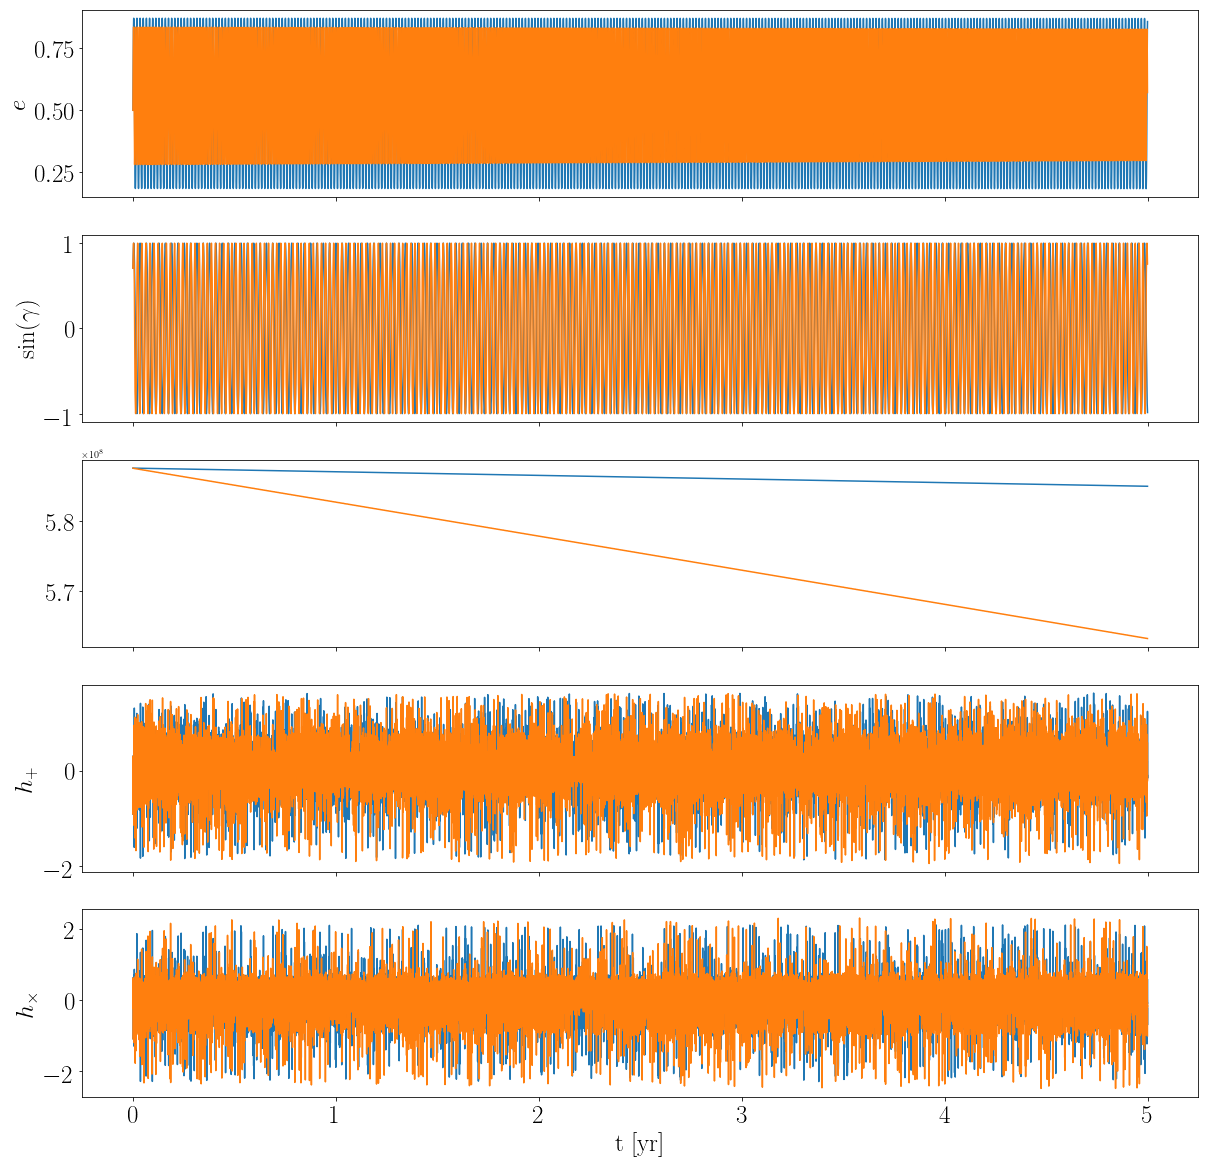

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((5,1), (0,0)) 
ax2 = plt.subplot2grid((5,1), (1,0)) 
ax3 = plt.subplot2grid((5,1), (2,0)) 
ax4 = plt.subplot2grid((5,1), (3,0)) 
ax5 = plt.subplot2grid((5,1), (4,0)) 


m0 = 30*Msolar
m1 = 30*Msolar
f1 = 1e-3 #orbital frequency
e1 = 0.5 #eccentricity
beta=100
m2 = 50*Msolar
e2 =0.6
I = 60 * np.pi/180.0 #Inclination
gamma = np.pi/4
iota = 20 * np.pi/180  #angle of L vector w.r.t observer LOS 
nsum = 20 #num modes to sum over






#Stability condition a2/a1 > stability
stability = 2.8/(1-e2) * ((m2)/(m0+m1) * (1+e2)/(1-e2)**(2/5))**(2/5)


brange = np.arange(200,300,10)
brange = [10]

Kozai = 1 #Turn on/off Kozai osc
PN = 1
GW = 1
t_res = int(3e4)


for b in brange:
    
    if b < stability:
        print ('Breaks stability condition ', b, ' <' , stability)
    
    Kozai = 1
    t1, h1 =  plotall(m0,m1,f1,e1,b,m2,e2,I,gamma,t_res)
    
    #Kozai = 0
    #t0, h0 =  plotall(m0,m1,f1,e1,b,m2,e2,I,gamma,t_res)

    
    

#Approximate gamma


zoom = 0
NicePlot(zoom)
#plt.savefig('Figs/quick2.png', dpi = 300)

ValueError: operands could not be broadcast together with shapes (30000,) (35000,) 

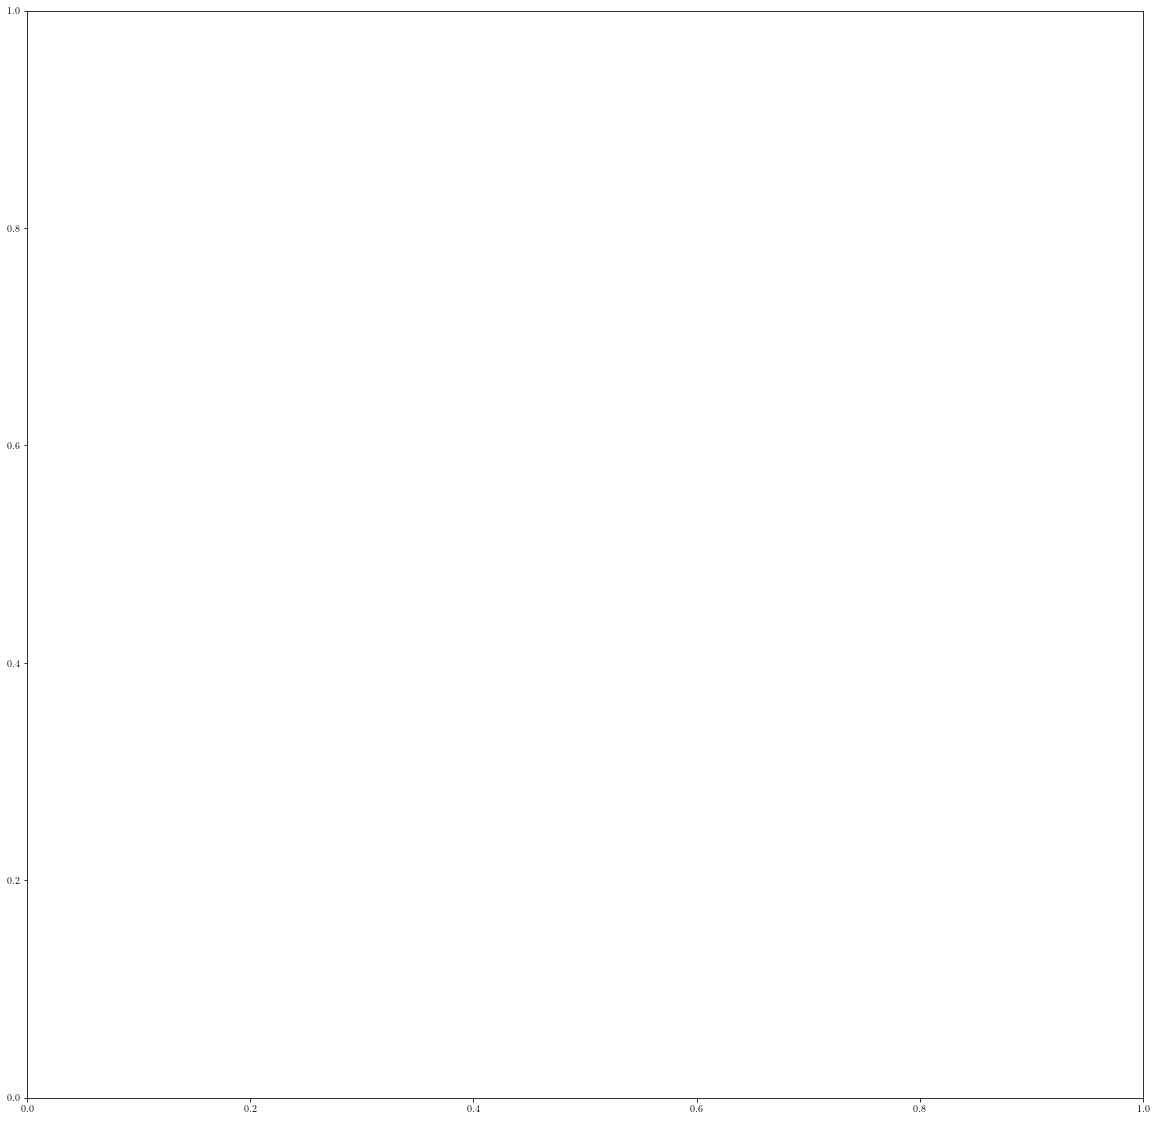

In [624]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,1), (0,0)) 

dh = h1 - h0
ax1.plot(t0, dh)
ax1.set_xlim(0.6,0.7)